In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
from core import Game, Visualization, Controller

To preview this jupyter notebook md in vscode, launch VS Code Quick Open (Ctrl+P), paste the following command, and press enter.
```sh
ext install jithurjacob.nbpreviewer
```


# **Single Agent Object-Pickup Problem**

## **Problem Description**

This task involves an agent navigating a 5x5 grid world to pick up an item located at a random position `A` and delivering it to a fixed destination `B`, located at the bottom-right corner of the grid. The agent must learn to complete this task as efficiently as possible, regardless of its starting position.

## **Methodology**

The agent uses Q-learning to learn an optimal policy. The algorithm updates the Q-values stored in a Q-table based on the agent's interactions with the environment, gradually improving its strategy over time.
Q table is initialised at ...
The learning rate Alpha is set at 0.1

### **State Space**

The state space is defined by the agent’s position on the grid, the location of the item (A), and whether the agent is carrying the item. This can be represented as a tuple `((agent_coor_x, agent_coor_y), has_item)` where `has_item` is a boolean variable indicating if the agent has picked up the item.

### **Action Space**

The agent can perform one of four actions at any given time:

- **Move North**
- **Move South**
- **Move West**
- **Move East**

These actions move the agent one step in the corresponding direction unless the movement would result in the agent hitting a wall, in which case the agent remains in the same position.

### **Reward Structure**

The reward structure is designed to guide the agent toward efficiently solving the task:

|    **Event**    | **Reward** |
|:---------------|-----------:|
| Picking up the item at `A` | +50 |
| Delivering the item to `B` | +50 |
| Moving to an empty grid | -1 |
| Hitting a wall | -10 |

This reward system incentivizes the agent to quickly locate and pick up the item and then deliver it to the goal while penalizing unnecessary movements and collisions with walls.

## **Performance Metrics**

### **Loss-against-Iteration Graph**

To evaluate the agent’s learning progress, we track the loss against the number of iterations.

#### **Maximum Reward Calculation**

For each episode, the maximum possible reward is calculated by determining the optimal route:

1. **Agent → Item**: Calculate the Manhattan distance between the agent’s starting position and the item's location.
2. **Item → Goal**: Calculate the Manhattan distance between the item's location and the goal at `B`.

The maximum possible reward is computed by subtracting the sum of these distances from 102 (which includes the reward for picking up the item, delivering it to the goal, and a 2-point compensation for the optimal path).

#### **Loss Calculation**

The loss for each iteration is calculated as the difference between the maximum possible reward and the actual reward obtained by the agent in that iteration. This loss is then plotted against the number of iterations to visualize the agent’s learning progress.

### **Epsilon Decay Graph**

The Epsilon decay graph illustrates how the exploration rate (`ε`) changes over time. Initially, the agent explores more (`high ε`), but as learning progresses, `ε` decays, leading the agent to exploit known information more often. This graph provides insight into the balance between exploration and exploitation throughout the training process.


## <u>Visualisation</u>

- Press Reset

We initialize a new game and train the agent for 500 times

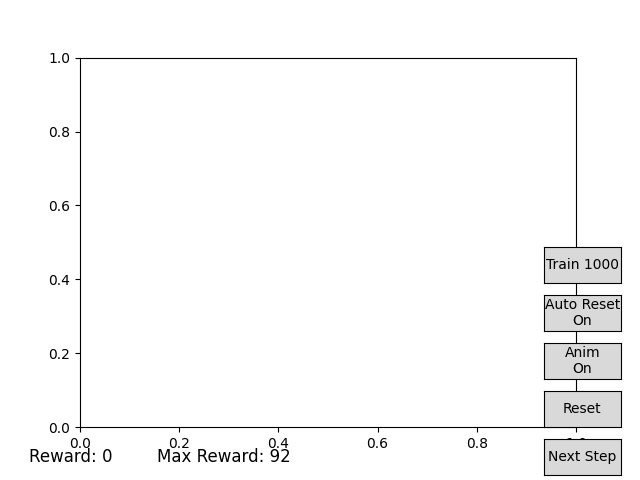

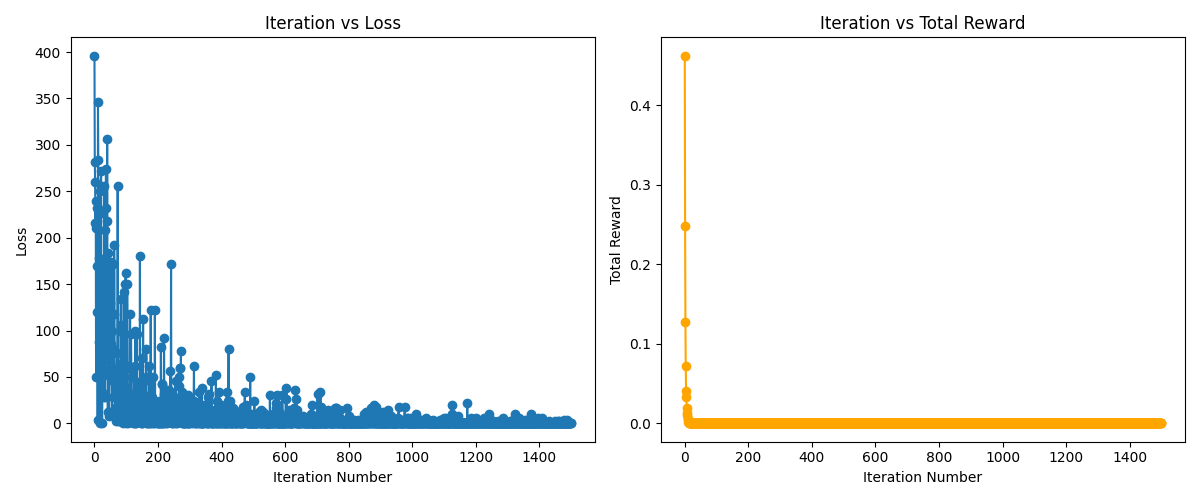

In [3]:
game = Game()
times = 500
controller = Controller(game, times)
controller.train(times)
fig1, ax1 = plt.subplots()
vis = Visualization(game, controller, fig1, ax1)

After training it for 500 times, we can see that the agent can sparingly complete the goal, but more often times it oscillates between 2 cells, or being stuck at the corner/near a wall, not completing the task. We can see that the performance metrics below:

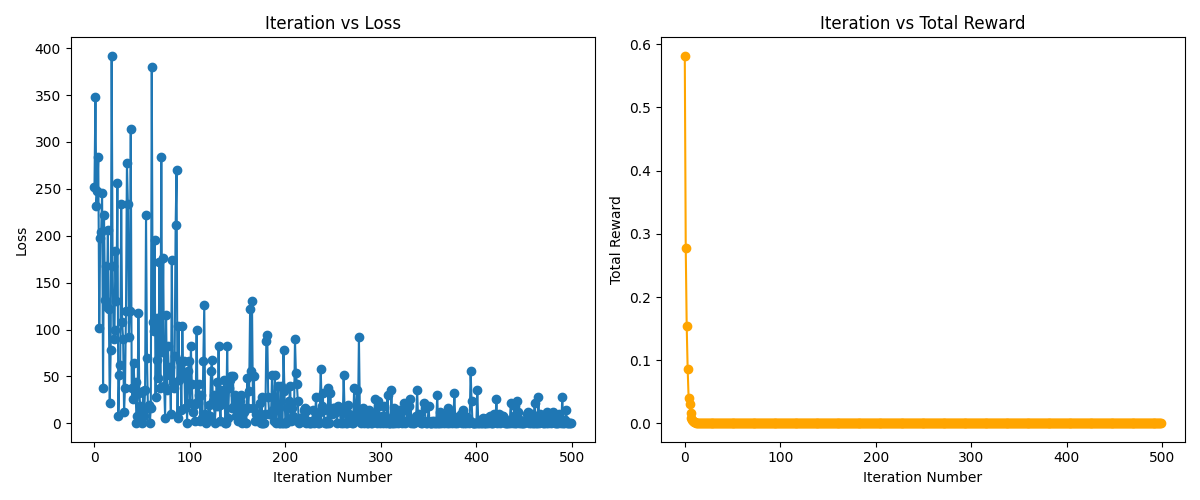

In [4]:
Visualization.plot_training(controller.get_metrics())

As seen above, The loss at 500th iteration hasn't converged to 0, there is still room for improvement for our agent.

Now, we allow it to train 1000 more times

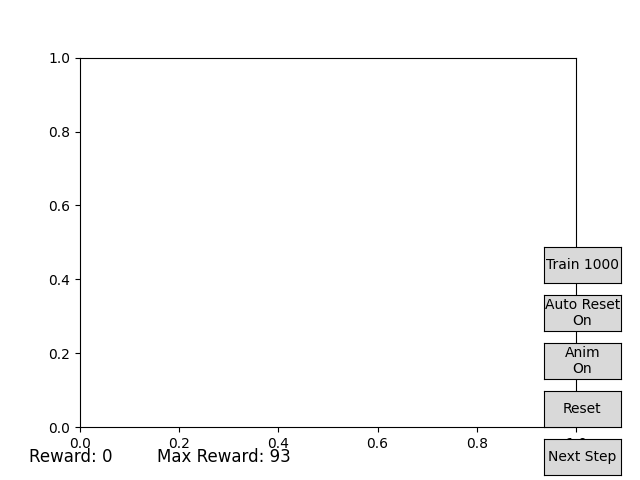

In [5]:
game2 = Game()
times = 1500
controller2 = Controller(game2, times)
controller2.train(times)
fig1, ax1 = plt.subplots()
vis2 = Visualization(game2, controller2, fig1, ax1)

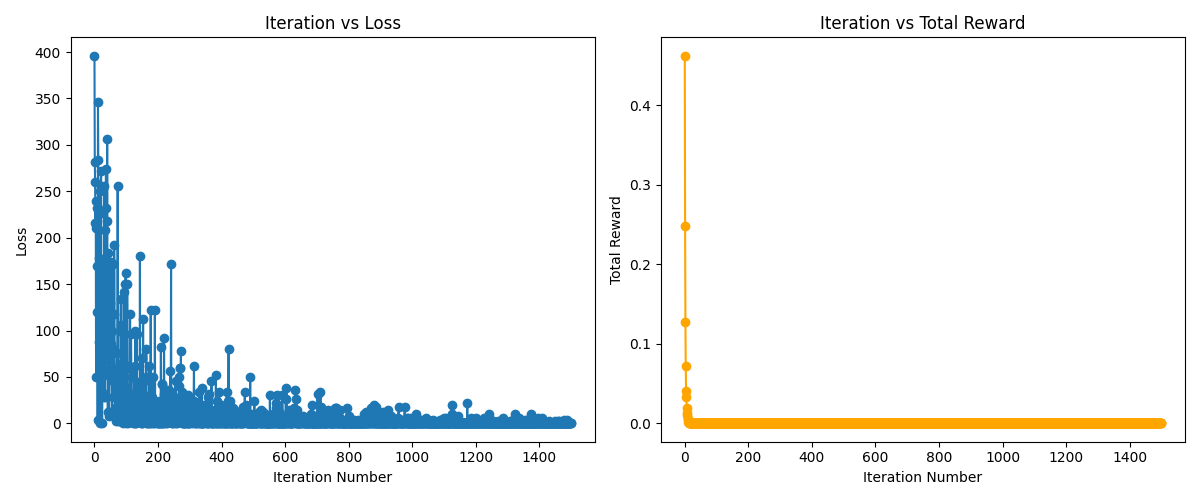

In [6]:

Visualization.plot_training(controller2.get_metrics())

The metrics graph is much better than before but we still havent converged yet. Lets train the agent up to 3000 times.

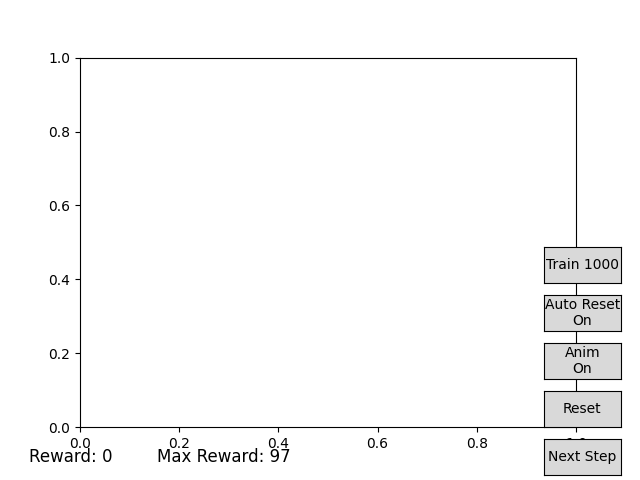

In [7]:
game3 = Game()
times = 3000
controller3 = Controller(game3, times)
controller3.train(times)
fig1, ax1 = plt.subplots()
vis3 = Visualization(game3, controller3, fig1, ax1)


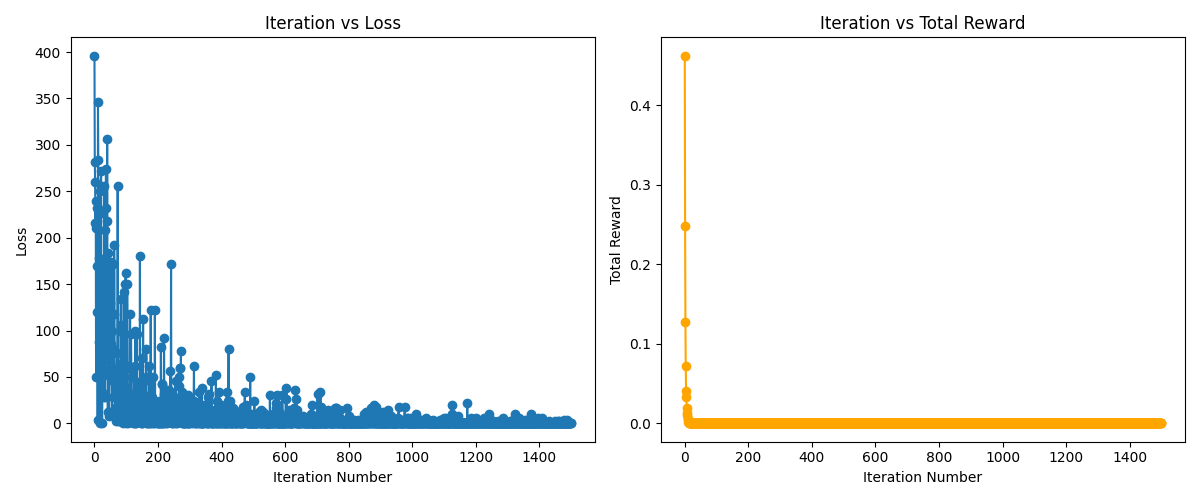

In [8]:

Visualization.plot_training(controller2.get_metrics())


If we observe the final few hundred iterations of the training, we can see that the loss is almost consistently 0. We can say that it has converged and the agent has fully learnt about the problem set.

# Conclusion
....